In [1]:
import os
import sys
import time
import math
import h5py
import numpy as np
from scipy.interpolate import RegularGridInterpolator
from datetime import datetime, timedelta

In [2]:
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/')
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/libs/')

from namelist import *
import data_utils as du
import vae_utils as vu
import model_utils as mu

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel('ERROR')

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def norm_precip(x):
    return np.log(x+1)

def norm_rh(x):
    return (x-50)/28/2

def norm_t(x):
    return (x-281)/10/2

def norm_u(x):
    return (x-3.5)/6.5/2

def norm_v(x):
    return (x)/6.5/2

def norm_pwat(x):
    return (x-20.5)/15/2

def norm_cape(x):
    return (x-200)/450/2

**Batch gen 2021**

In [6]:
with h5py.File(save_dir+'CNN_domain.hdf', 'r') as h5io:
    #print(h5io.keys())
    lon_01 = h5io['lon_01'][...]
    lat_01 = h5io['lat_01'][...]
    elev_01 = h5io['elev_01'][...]
    lon_GFS = h5io['lon_GFS'][...]
    lat_GFS = h5io['lat_GFS'][...]

elev_01[elev_01<0] = 0
elev_01 = elev_01/2000 - 1

**generating batches**

In [7]:
x_mrms = 256
y_mrms = 576
x_gfs = 105
y_gfs = 242

## Encoder network

In [8]:
def resblock(X, kernel_size, filter_num, activation):
    Fx = layers.Conv2D(filter_num, kernel_size, padding='same')(X)
    Fx = layers.BatchNormalization()(Fx)
    Fx = layers.Activation(activation)(Fx)
    Fx = layers.Conv2D(filter_num, kernel_size, padding='same')(Fx)
    out = layers.Add()([X, Fx])
    out = layers.BatchNormalization(axis=-1)(out)
    out = layers.Activation(activation)(out)
    return out

In [9]:
filter_nums = [64, 128]
latent_dim = 16
num_embeddings = 128
activation = 'relu'

model_name_save = '/glade/work/ksha/GAN/models/VQ_VAE_P128_{}_{}_L{}_N{}_{}_tune4'.format(filter_nums[0], 
                                                                                            filter_nums[1], 
                                                                                            latent_dim, 
                                                                                            num_embeddings, 
                                                                                            activation)


input_size = (128, 128, 1) #(28, 28, 1) #
latent_size = (32, 32, latent_dim) #(7, 7, latent_dim) #
# 64 144

# encoder
encoder_in = keras.Input(shape=input_size)
X = encoder_in

X = layers.Conv2D(filter_nums[0], 3, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = layers.Conv2D(filter_nums[0], 3, strides=2, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = resblock(X, 3, filter_nums[0], activation)
X = resblock(X, 3, filter_nums[0], activation)

X = layers.Conv2D(filter_nums[1], 3, strides=2, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = resblock(X, 3, filter_nums[1], activation)
X = resblock(X, 3, filter_nums[1], activation)

encoder_out = layers.Conv2D(latent_dim, 1, padding="same")(X)

model_encoder_mrms = keras.Model(encoder_in, encoder_out)

# decoder
decoder_in = keras.Input(shape=latent_size)

X = decoder_in

X = layers.Conv2D(filter_nums[1], 1, padding="same")(X)

X = layers.Conv2DTranspose(filter_nums[1], 3, strides=2, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = resblock(X, 3, filter_nums[1], activation)
X = resblock(X, 3, filter_nums[1], activation)

X = layers.Conv2DTranspose(filter_nums[0], 3, strides=2, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = resblock(X, 3, filter_nums[0], activation)
X = resblock(X, 3, filter_nums[0], activation)

decoder_out = layers.Conv2D(latent_dim, 1, padding="same")(X)

model_decoder = keras.Model(decoder_in, decoder_out)

# VQ-VAE
IN = keras.Input(shape=input_size)
X = IN
X_encode = model_encoder_mrms(X)

vq_layer = vu.VectorQuantizer(num_embeddings, latent_dim)
X_VQ = vq_layer(X_encode)
OUT = model_decoder(X_VQ)
model_vqvae = keras.Model(IN, OUT)
vqvae_trainer = vu.VQVAETrainer(model_vqvae, 1.0, latent_dim, num_embeddings)

In [10]:
W_old = mu.dummy_loader(model_name_save)
model_vqvae.set_weights(W_old)
model_encoder_mrms.compile(loss=tf.keras.losses.mean_absolute_error, optimizer=keras.optimizers.Adam(learning_rate=0))

## GFS embedding network

In [11]:
# Kernel initializer to use
def kernel_init(scale):
    scale = max(scale, 1e-10)
    return keras.initializers.VarianceScaling(
        scale, mode="fan_avg", distribution="uniform"
    )

class TimeEmbedding(layers.Layer):
    def __init__(self, dim, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.half_dim = dim // 2
        self.emb = math.log(10000) / (self.half_dim - 1)
        self.emb = tf.exp(tf.range(self.half_dim, dtype=tf.float32) * -self.emb)

    def call(self, inputs):
        inputs = tf.cast(inputs, dtype=tf.float32)
        emb = inputs[:, None] * self.emb[None, :]
        emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=-1)
        return emb


def ResidualBlock(width, activation_fn=keras.activations.relu):
    def apply(inputs):
        x, t = inputs
        input_width = x.shape[3]

        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(
                width, kernel_size=1, kernel_initializer=kernel_init(1.0)
            )(x)

        temb = activation_fn(t)
        temb = layers.Dense(width, kernel_initializer=kernel_init(1.0))(temb)[
            :, None, None, :
        ]

        x = layers.BatchNormalization()(x)
        x = activation_fn(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", kernel_initializer=kernel_init(1.0)
        )(x)

        x = layers.Add()([x, temb])
        x = layers.BatchNormalization()(x)
        x = activation_fn(x)

        x = layers.Conv2D(
            width, kernel_size=3, padding="same", kernel_initializer=kernel_init(0.0)
        )(x)
        x = layers.Add()([x, residual])
        return x

    return apply

def TimeMLP(units, activation_fn=keras.activations.relu):
    def apply(inputs):
        temb = layers.Dense(
            units, activation=activation_fn, kernel_initializer=kernel_init(1.0)
        )(inputs)
        temb = layers.Dense(units, kernel_initializer=kernel_init(1.0))(temb)
        return temb

    return apply

In [12]:
filter_nums = [64, 256] #[32, 64, 128]
activation = 'relu'
input_size = (128, 128, 8)
latent_size = (32, 32, filter_nums[-1])

model_name_save = '/glade/work/ksha/GAN/models/BC_{}_{}_{}_base'.format(filter_nums[0], 
                                                                        filter_nums[1], 
                                                                        activation)

time_input = keras.Input(shape=(), dtype=tf.int64)
temb = TimeEmbedding(dim=filter_nums[0]*4)(time_input)
temb = TimeMLP(units=filter_nums[0]*4)(temb)

# encoder
encoder_in = keras.Input(shape=input_size)
X = encoder_in

X = layers.Conv2D(filter_nums[0], 3, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = layers.Conv2D(filter_nums[0], 3, strides=2, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = ResidualBlock(filter_nums[0],)([X, temb])
X = ResidualBlock(filter_nums[0],)([X, temb])

X = layers.Conv2D(filter_nums[1], 3, strides=2, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = ResidualBlock(filter_nums[1],)([X, temb])
X = ResidualBlock(filter_nums[1],)([X, temb])

encoder_out = X

model_encoder = keras.Model([encoder_in, time_input], encoder_out)

# decoder
decoder_in = keras.Input(shape=latent_size)

time_input = keras.Input(shape=(), dtype=tf.int64)

temb = TimeEmbedding(dim=filter_nums[0]*4)(time_input)
temb = TimeMLP(units=filter_nums[0]*4)(temb)

X = decoder_in

X = layers.Conv2DTranspose(filter_nums[1], 3, strides=2, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = ResidualBlock(filter_nums[1],)([X, temb])
X = ResidualBlock(filter_nums[1],)([X, temb])

X = layers.Conv2DTranspose(filter_nums[0], 3, strides=2, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = ResidualBlock(filter_nums[0],)([X, temb])
X = ResidualBlock(filter_nums[0],)([X, temb])

decoder_out = layers.Conv2D(1, 1, padding="same")(X)

model_decoder = keras.Model([decoder_in, time_input], decoder_out)

# BC network
time_input = keras.Input(shape=(), dtype=tf.int64)

IN = keras.Input(shape=input_size)
X_encode = model_encoder([IN, time_input])
OUT = model_decoder([X_encode, time_input])
model = keras.Model([IN, time_input], OUT)

In [13]:
model.compile(loss=keras.losses.mean_absolute_error, optimizer=keras.optimizers.Adam(learning_rate=0))
W_old = mu.dummy_loader(model_name_save)
model.set_weights(W_old)

In [14]:
size = 128
gap = 24
grid_shape = (x_mrms, y_mrms)

In [16]:
data = np.empty((1, x_mrms, y_mrms, 10))
gfs = np.empty((1, x_gfs, y_gfs, 8))

# ======================================================== #
year = 2021
base = datetime(year, 1, 1)
date_list = [base + timedelta(days=d) for d in range(365)]
LEADs = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36] #
INIs = [0, 6, 12, 18]
# ======================================================== #

with h5py.File('/glade/campaign/cisl/aiml/ksha/GFS/MRMS_y{}.hdf'.format(year), 'r') as h5io:
    MRMS = h5io['MRMS'][...]

BATCH_dir = '/glade/campaign/cisl/aiml/ksha/BATCH_LDM/'

batch_file_name = 'GFS_y{:04d}_ini{:02d}_lead{:02d}_dt{:04d}_ix{:03d}_iy{:03d}.npy'

name_gfs = '/glade/campaign/cisl/aiml/ksha/GFS/GFS_{}_ini{:02d}_f{:02d}.hdf'
name_apcp = '/glade/campaign/cisl/aiml/ksha/GFS/GFS_APCP_{}_ini{:02d}_f{:02d}.hdf'


for lead in LEADs:
    for ini in INIs:

        with h5py.File(name_gfs.format(year, ini, lead), 'r') as h5io:
            CAPE = h5io['CAPE'][...]
            PWAT = h5io['PWAT'][...]
            T800 = h5io['T800'][...]
            U800 = h5io['U800'][...]
            V800 = h5io['V800'][...]
            RH800 = h5io['RH800'][...]
        
        with h5py.File(name_apcp.format(year, ini, lead), 'r') as h5io:
            APCP = h5io['APCP'][...]

        # ======================================================== #
        for i_dt, dt in enumerate(date_list[:1]):
        
            N_hours = i_dt*24 + ini + lead
            if N_hours < 8760:
                MRMS_temp = MRMS[N_hours, ...] + MRMS[N_hours-1, ...] + MRMS[N_hours-2, ...]
                
                hr_to_lr = RegularGridInterpolator((lat_01[:, 0], lon_01[0, :]), MRMS_temp, 
                                                   bounds_error=False, fill_value=None)
                MRMS_lr = hr_to_lr((lat_GFS, lon_GFS))
                
                gfs[..., 0] = MRMS_lr
                gfs[..., 1] = APCP[i_dt, ...]
                gfs[..., 2] = CAPE[i_dt, ...]
                gfs[..., 3] = PWAT[i_dt, ...]
                gfs[..., 4] = T800[i_dt, ...]
                gfs[..., 5] = U800[i_dt, ...]
                gfs[..., 6] = V800[i_dt, ...]
                gfs[..., 7] = RH800[i_dt, ...]
                
                data[..., 0] = MRMS_temp
                
                for i in range(8):
                    lr_to_hr = RegularGridInterpolator((lat_GFS[:, 0], lon_GFS[0, :]), gfs[0, ..., i], 
                                                       bounds_error=False, fill_value=None)
                    data[..., i+1] = lr_to_hr((lat_01, lon_01))
                
                temp = data[..., 1]
                temp[temp < 0] = 0
                data[..., 1] = temp
                
                data[..., 0] = norm_precip(data[..., 0])
                data[..., 1] = norm_precip(data[..., 1])
                data[..., 2] = norm_precip(data[..., 2])
                data[..., 3] = norm_cape(data[..., 3])
                data[..., 4] = norm_pwat(data[..., 4])
                data[..., 5] = norm_t(data[..., 5])
                data[..., 6] = norm_u(data[..., 6])
                data[..., 7] = norm_v(data[..., 7])
                data[..., 8] = norm_rh(data[..., 8])
                data[..., 9] = elev_01

                for ix in range(0, grid_shape[0]+gap, gap):
                    for iy in range(0, grid_shape[1]+gap, gap):
                        ix_start = ix
                        ix_end = ix+size
            
                        iy_start = iy
                        iy_end = iy+size
            
                        if (ix_end < grid_shape[0]) and (iy_end < grid_shape[1]):
                            temp_mrms_flag = data[0, ix_start:ix_end, iy_start:iy_end, 0]
                            if np.sum(temp_mrms_flag > 0.1) > 4000:
                                if np.sum(np.isnan(data)) == 0:
                                    data_temp = data[:, ix_start:ix_end, iy_start:iy_end, :]
                
                                    # encoder for latent diffusion model training
                                    Y_latent = model_encoder_mrms.predict(data_temp[..., 0][..., None])
                                    Y_latent_code = np.array(vq_layer(Y_latent))
                                    
                                    # encoder for bias-correction
                                    lead_t = lead*np.ones(1,)
                                    GFS_latent = model_encoder.predict([data_temp[..., 2:], lead_t])
    
                                    data_save = {}
                                    data_save['Y_latent'] = Y_latent_code
                                    data_save['GFS_latent'] = GFS_latent
                                    data_save['MRMS'] = data_temp[..., 0][..., None]

                                    name_ = BATCH_dir+batch_file_name.format(year, ini, lead, i_dt, ix, iy)
                                    print(name_)
                                    np.save(name_, data_save)

1/1 [==============================] - 0s 268ms/step
/glade/campaign/cisl/aiml/ksha/BATCH_Diffusion/GFS_y2021_ini00_lead03_dt0000_ix000_iy192.npy
1/1 [==============================] - 0s 18ms/step
/glade/campaign/cisl/aiml/ksha/BATCH_Diffusion/GFS_y2021_ini00_lead03_dt0000_ix000_iy216.npy
1/1 [==============================] - 0s 16ms/step
/glade/campaign/cisl/aiml/ksha/BATCH_Diffusion/GFS_y2021_ini00_lead03_dt0000_ix000_iy240.npy
1/1 [==============================] - 0s 16ms/step
/glade/campaign/cisl/aiml/ksha/BATCH_Diffusion/GFS_y2021_ini00_lead03_dt0000_ix000_iy264.npy
1/1 [==============================] - 0s 16ms/step
/glade/campaign/cisl/aiml/ksha/BATCH_Diffusion/GFS_y2021_ini00_lead03_dt0000_ix000_iy288.npy
1/1 [==============================] - 0s 21ms/step
/glade/campaign/cisl/aiml/ksha/BATCH_Diffusion/GFS_y2021_ini00_lead03_dt0000_ix000_iy312.npy
1/1 [==============================] - 0s 15ms/step
/glade/campaign/cisl/aiml/ksha/BATCH_Diffusion/GFS_y2021_ini00_lead03_dt0000_


KeyboardInterrupt



In [17]:
temp_data = np.load('/glade/campaign/cisl/aiml/ksha/BATCH_Diffusion/GFS_y2021_ini06_lead15_dt0000_ix096_iy432.npy', allow_pickle=True)[()]

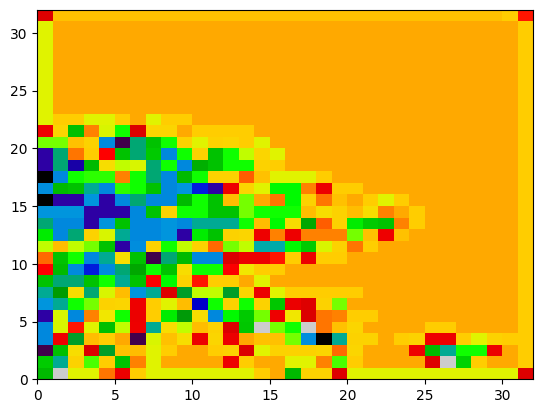

In [18]:
plt.pcolormesh(temp_data['Y_latent'][0, ..., 1], cmap=plt.cm.nipy_spectral_r)

In [23]:
#plt.hist(temp_data['Y_latent'].ravel(), bins=np.linspace(-2.5, 2.5, 100));

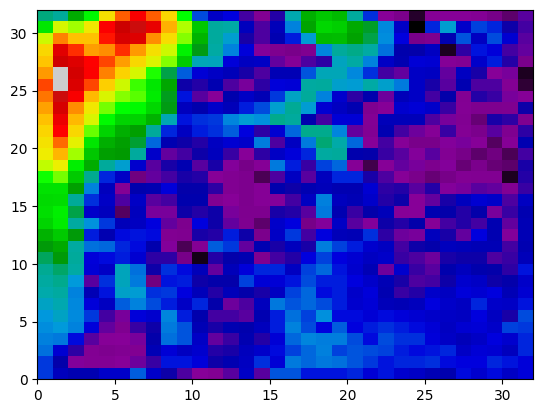

In [35]:
plt.pcolormesh(temp_data['GFS_latent'][0, ..., -1], cmap=plt.cm.nipy_spectral_r)

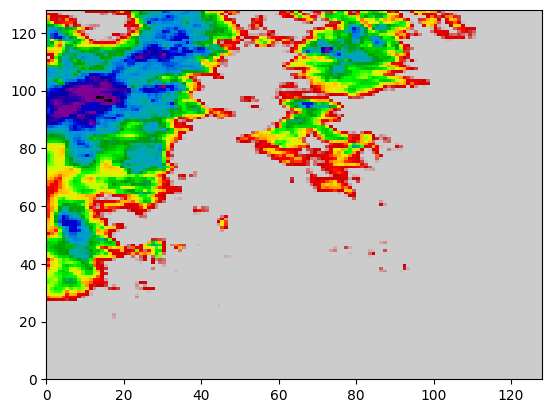

In [36]:
plt.pcolormesh(temp_data['MRMS'][0, ..., 0], cmap=plt.cm.nipy_spectral_r)